## Introduction

In this assignment, you are going to build a classifier for named entities from the Groningen Meaning Bank corpus.  Named entity recognition (NER) takes noun phrases from a text and identifies whether they are persons, organizations, and so on.  You will be using the Groningen Meaning Bank named entity corpus available on mltgpu at `/scratch/lt2222-v21-resources/GMB_dataset.txt`.  In this version of the task, you will assume we know *that* something is a named entity, and instead use multi-class classification to identify its type.  So you will be doing named entity classification but *not* recognition.

The data looks like this: 

```
3996    182.0   Nicole  NNP     B-per
3997    182.0   Ritchie NNP     I-per
3998    182.0   is      VBZ     O
3999    182.0   pregnant        JJ      O
4000    182.0   .       .       O
4001    183.0   Speaking        VBG     O
4002    183.0   to      TO      O
4003    183.0   ABC     NNP     B-org
4004    183.0   News    NNP     I-org
4005    183.0   interviewer     NN      O
4006    183.0   Dianne  NNP     B-per
4007    183.0   Sawyer  NNP     I-per
4008    183.0   ,       ,       O
4009    183.0   the     DT      O
4010    183.0   25-year-old     JJ      O
4011    183.0   co-star NN      O
4012    183.0   of      IN      O
4013    183.0   TV      NN      O
4014    183.0   's      POS     O
4015    183.0   The     DT      B-art
4016    183.0   Simple  NNP     I-art
4017    183.0   Life    NNP     I-art
4018    183.0   said    VBD     O
4019    183.0   she     PRP     O
4020    183.0   is      VBZ     O
4021    183.0   almost  RB      O
4022    183.0   four    CD      O
4023    183.0   months  NNS     O
4024    183.0   along   IN      O
4025    183.0   in      IN      O
4026    183.0   her     PRP$    O
4027    183.0   pregnancy       NN      O
4028    183.0   .       .       O
```

The first column is the line number.  The second column is a sentence number (for some reason given as a float; ignore it).  The third column is the word.  The fourth column is a part of speech (POS) tag in Penn Treebank format.  The last column contains the named entity annotation. 

The annotation works like this.  Every `O` just means that the row does not represent a named entity.  `B-xyx` means the first word in a named entity with type `xyx`. `I-xyz` means the second and later words of an `xyz` entity, if there are any.  That means that every time there's a `B` or an `I`, there's a named entity.  

The entity types in the corpus are `art`,
`eve`,
`geo`,
`gpe`,
`nat`,
`org`,
`per`,
and `tim`

Your task is the following.
1. To preprocess the text (lowercase and lemmatize; punctuation can be preserved as it gets its own rows).
2. To create instances from every from every identified named entity in the text with the type of the NE as the class, and a surrounding context of five words on either side as the features.  
3. To generate vectors and split the instances into training and testing datasets at random.
4. To train a support vector machine (via `sklearn.svm.LinearSVC`) for classifying the NERs.
5. To evaluate the performance of the classifier.

You will do this by modifying a separate file containing functions that will be called from this notebook as a module.  You can modify this notebook for testing purposes but please only submit the original.  You will document everything in Markdown in README.md and submit a GitHub repository URL.

This assignment is due on
**Tuesday, 2021 March 9 at 23:59**.  It has **25 points** and **7 bonus points**.

In [ ]:
!pip install lazypredict #try to use lazypredict classifier for the first time (optional)

In [2]:
import a2
import pandas as pd
import importlib
import numpy as np
import scikitplot as skplt

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_confusion_matrix,confusion_matrix

import matplotlib.pyplot as plt

#import lazypredict
#from lazypredict.Supervised import LazyClassifier

ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.8 from "/Volumes/DATA2/Anaconda3/anaconda3/envs/dataviz/bin/python"
  * The NumPy version is: "1.19.2"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: dlopen(/Volumes/DATA2/Anaconda3/anaconda3/envs/dataviz/lib/python3.8/site-packages/numpy/core/_multiarray_umath.cpython-38-darwin.so, 2): Library not loaded: @rpath/libopenblas.dylib
  Referenced from: /Volumes/DATA2/Anaconda3/anaconda3/envs/dataviz/lib/python3.8/site-packages/numpy/core/_multiarray_umath.cpython-38-darwin.so
  Reason: image not found


## Part 1 - preprocessing (3 points)

See step 1 above.  The data is coming to you as an unused file handle object.  You can return the data in any indexable form you like.  You can also choose to remove infrequent or uninformative words to reduce the size of the feature space. (Document this in README.md.)

In [6]:
gmbfile = open('GMB_dataset.txt', "r")
inputdata = a2.preprocess(gmbfile)
inputdata[20:40]

,Sentence #,Word,POS,Tag,Tag_prefix,Tag_entity,Word_seq
36,2.0,banner,NNS,O,O,None,8
39,2.0,slogan,NNS,O,O,None,9
41,2.0,"""""""""",``,O,O,None,10
42,2.0,bush,NNP,B-per,B,per,11
43,2.0,number,NN,O,O,None,12
44,2.0,one,CD,O,O,None,13
45,2.0,terrorist,NN,O,O,None,14
46,2.0,"""""""""",``,O,O,None,15
48,2.0,"""""""""",``,O,O,None,16
49,2.0,stop,VB,O,O,None,17


In [7]:
inputdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43977 entries, 0 to 66160
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Sentence #  43977 non-null  object
 1   Word        43977 non-null  object
 2   POS         43977 non-null  object
 3   Tag         43977 non-null  object
 4   Tag_prefix  43977 non-null  object
 5   Tag_entity  9736 non-null   object
 6   Word_seq    43977 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 2.7+ MB


## Part 2 - Creating instances (7 points)

Do step 2 above.  You will create a collection of Instance objects.  Remember to consider the case where the NE is at the beginning of a sentence or at the end, or close to either (you can create a special start token for that).  You can also start counting from before the `B` end of the NE mention and after the last `I` of the NE mention. That means that the instances should include things before and after the named entity mention, but not the named entity text itself.

In [8]:
instances = a2.create_instances(inputdata,n=5,skip_ne=True)

In [9]:
instances[20:40]

,0,1,2,3,4,5,6,7,8,9
geo,percent,world,smoker,thought,live,alone,S5,S4,S3,S2
geo,S5,world,smoker,thought,live,alone,S5,S4,S3,S2
gpe,S1,S2,S3,S4,S5,military,launched,offensive,hunt,S5
geo,S4,S5,military,launched,offensive,hunt,insurgent,S5,S4,S3
org,S5,military,launched,offensive,hunt,insurgent,S5,S4,S3,S2
nat,die,cancer,soon,greater,death,tuberculosis,malaria,combined,S5,S4
tim,may,rise,27,million,year,17,million,people,dying,disease
org,force,tried,suppress,report,abuse,prisoner,S5,S4,S3,S2
org,S3,S4,S5,document,released,say,S5,S4,S3,S2
org,S3,S4,S5,document,released,say,staff,S5,S4,S3


## Part 3 - Creating the table and splitting (10 points)

Here you're going to write the functions that create a data table with "document" vectors representing each instance and split the table into training and testing sets and random with an 80%/20% train/test split.

In [10]:
importlib.reload(a2)

bigdf = a2.create_table(instances,method='tfidf')
bigdf[20:40]

,_class_,10,100,103,11,110,119,12,120,123,...,wrongdoing,yankee,year,yet,young,younger,youth,zawahiri,zionist,zone
20,geo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,geo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,gpe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,geo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,org,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,nat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,tim,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.190485,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,org,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,org,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,org,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
train_X, train_y, test_X, test_y = a2.ttsplit(bigdf)

In [12]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7184, 4085) (7184,) (1796, 4085) (1796,)


In [13]:
len(test_y) / (len(test_y) + len(train_y))

0.2

In [14]:
len(test_X) / (len(test_X) + len(train_X))

0.2

In [15]:
test_y[0]

'per'

## Part 4 - Training the model (0 points)

This part you won't do yourself.

In [16]:
model = LinearSVC()
model.fit(train_X, train_y)
train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)

In [17]:
train_predictions

array(['tim', 'geo', 'gpe', ..., 'org', 'per', 'org'], dtype=object)

In [18]:
train_y

array(['gpe', 'geo', 'gpe', ..., 'org', 'per', 'org'], dtype=object)

In [19]:
test_predictions

array(['per', 'per', 'per', ..., 'org', 'geo', 'per'], dtype=object)

In [20]:
test_y

array(['per', 'org', 'gpe', ..., 'org', 'geo', 'per'], dtype=object)

In [21]:
#model = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
#model.fit(train_X, train_y)


## Part 5 - Evaluation (5 points)

Investigate for yourself what a "confusion matrix".  Then implement a function that takes the data and produces a confusion matrix in any readable form that allows us to compare the performance of the model by class.  

In [37]:
model.score(train_X,train_y),model.score(test_X,test_y)

(0.8009465478841871, 0.5027839643652561)

In [ ]:
importlib.reload(a2)
a2.confusion_matrix(test_y, test_predictions)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

<Figure size 576x576 with 0 Axes>

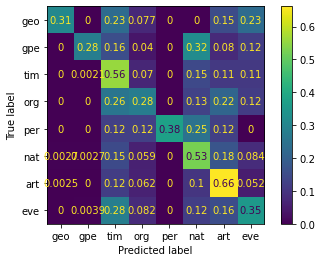

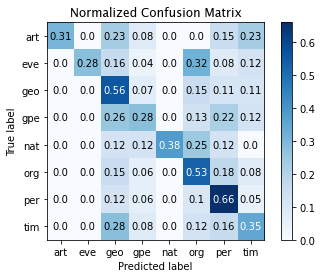

In [36]:
importlib.reload(a2)

#a2.confusion_matrix(model,test_y, test_predictions)
np.set_printoptions(precision=2)
fig = plt.figure(figsize=(8,8))
class_names = bigdf['_class_'].unique()

disp = plot_confusion_matrix(model,test_X, test_y,
                                 display_labels=class_names,
                                 normalize='true')

confusion_matrix(test_y,test_predictions)


skplt.metrics.plot_confusion_matrix(test_y, test_predictions, normalize=True)

Examine the matrix and describe your observations in README.md.  In particular, what do you notice about the predictions on the training data compared to those on the test data.

## Bonus Part A - Error analysis (2 points)

Look at the weakest-performing classes in the confusion matrix (or any, if they all perform poorly to the same extent).  Find some examples in the test data on which the classifier classified incorrectly for those classes.  What do you think is the reason why those are hard?  Consider linguistic factors and statistical factors, if applicable.  Write your answer in README.md.

In [42]:
inputdata['Tag_entity'].value_counts().plot()

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

## Bonus Part B - Expanding the feature space (7 points)

Run the entire process above, but incorporate part-of-speech tag information into the feature vectors.  It's your choice as to how to do this, but document it in README.md.  Your new process should run from the single call below:

In [18]:
a2.bonusb('/scratch/lt2222-v21-resources/GMB_dataset.txt')